<a href="https://colab.research.google.com/github/KohsukeIde/Pycuda_101/blob/main/Pycuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install pycuda --quiet

##Element wise kernel

In [ ]:
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.elementwise import ElementwiseKernel
import pycuda.autoinit

In [ ]:
plus_one_kernel = ElementwiseKernel(
 "int *y, int*x",
 "y[i] = x[i] + 1",
 "plus_one"   
)

In [ ]:
num_components = 10
x = np.arange(num_components, dtype=np.int32)

In [ ]:
x_gpu = gpuarray.to_gpu(x)
y_gpu = gpuarray.zeros(num_components, dtype=np.int32)

In [ ]:
plus_one_kernel(y_gpu, x_gpu)

In [ ]:
y_gpu.get()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

In [ ]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

##SourceModule

In [ ]:
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.autoinit
import math

In [ ]:
module = SourceModule("""
__global__ void plus_one_kernel(int num_comp, int *y, int*x){
int i = threadIdx.x + blockDim.x * blockIdx.x;
if (i < num_comp){
  y[i] = x[i] + 1;
}
}
""")

In [ ]:
plus_one_kernel = module.get_function("plus_one_kernel")

In [ ]:
num_components = np.int32(10)
x = np.arange(num_components, dtype=np.int32)

In [ ]:
x_gpu = gpuarray.to_gpu(x)
y_gpu = gpuarray.zeros(num_components, dtype=np.int32)

In [ ]:
threads_per_block = (256, 1, 1)
blocks_per_grid = (math.ceil(num_components/threads_per_block[0]),1,1)

In [ ]:
plus_one_kernel(num_components, y_gpu, x_gpu, block=threads_per_block, grid=blocks_per_grid)

In [ ]:
y_gpu.get()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

##loading cu file

In [ ]:
import math
import numpy as np
import time
import pycuda.driver as drv
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule

In [ ]:
import pycuda.autoinit

In [ ]:
# cuda_file_path = os.path.abspath("./cuda")
cuda_file_path = "/content/drive/MyDrive/dev/cuda"

In [ ]:
module = SourceModule("""
#include "kernel_functions_for_math_1d.cu"
""",include_dirs=[cuda_file_path])

In [ ]:
plus_one_kernel = module.get_function("plus_one_kernel")

In [ ]:
num_components = np.int32(1e6)
x = np.arange(num_components, dtype=np.int32)

In [ ]:
x_gpu = gpuarray.to_gpu(x)
y_gpu = gpuarray.zeros(num_components, dtype=np.int32)

In [ ]:
threads_per_block = (256, 1, 1)
blocks_per_grid = (math.ceil(num_components/threads_per_block[0]) ,1 ,1)

In [ ]:
plus_one_kernel(num_components, y_gpu, x_gpu, block=threads_per_block, grid=blocks_per_grid)

In [ ]:
y_gpu.get()

array([      1,       2,       3, ...,  999998,  999999, 1000000],
      dtype=int32)

In [ ]:
time_start_cpu = time.time()
x = x + 1
time_end_cpu = time.time()

In [ ]:
print("CPU calculation {} [msec]".format(1000*(time_end_cpu - time_start_cpu)))

CPU calculation 1.621246337890625 [msec]


In [ ]:
time_start_gpu = drv.Event()
time_end_gpu = drv.Event()

In [ ]:
time_start_gpu.record()
plus_one_kernel(num_components, y_gpu, x_gpu, block=threads_per_block, grid=blocks_per_grid)
time_end_gpu.record()
time_end_gpu.synchronize()

In [ ]:
print("GPU calculation {} [msec]".format(time_start_gpu.time_till(time_end_gpu)))

GPU calculation 0.16441600024700165 [msec]


In [ ]:
time_start_gpu.record()
y_gpu.get()
time_end_gpu.record()
time_end_gpu.synchronize()

In [ ]:
print("Taking memory from gpu {} [msec]".format(time_start_gpu.time_till(time_end_gpu)))

Taking memory from gpu 2.708479881286621 [msec]


## 2d array

In [ ]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [ ]:
module = SourceModule("""
__global__ void add_two_array_2d(int nx, int ny, float *res, float *arr1, float *arr2){
  int x = threadIdx.x + blockDim.x * blockIdx.x;
  int y = threadIdx.y + blockDim.y * blockIdx.y;
  int ij = nx * y + x;
  if (x < nx && y < ny){
      res[ij] = arr1[ij] + arr2[ij]; 
  }
}
""")

In [ ]:
add_two_array = module.get_function("add_two_array_2d")

In [ ]:
num_x, num_y = np.int32(5), np.int32(2)
num_components = num_x * num_y

In [ ]:
arr1 = np.arange(num_components, dtype=np.float32).reshape(num_y, num_x)

In [ ]:
np.random.seed(42)
arr2 = 10 * np.random.rand(num_y, num_x)
arr2 = arr2.astype(np.float32)

In [ ]:
res = np.zeros([num_y, num_x], dtype=np.float32)

In [ ]:
arr1_gpu = gpuarray.to_gpu(arr1)
arr2_gpu = gpuarray.to_gpu(arr2)
res_gpu = gpuarray.to_gpu(res)

In [ ]:
threads_per_block = (16, 16, 1)
block_x = math.ceil(num_x / threads_per_block[0])
block_y = math.ceil(num_y / threads_per_block[1])
blocks_per_grid = (block_x, block_y, 1)

In [ ]:
add_two_array(num_x, num_y, res_gpu, arr1_gpu, arr2_gpu, block=threads_per_block, grid=blocks_per_grid)

In [ ]:
res_gpu.get()

array([[ 3.7454011, 10.507143 ,  9.31994  ,  8.986585 ,  5.5601864],
       [ 6.559945 ,  6.5808363, 15.661761 , 14.01115  , 16.080727 ]],
      dtype=float32)

In [ ]:
arr1 + arr2

array([[ 3.7454011, 10.507143 ,  9.31994  ,  8.986585 ,  5.5601864],
       [ 6.559945 ,  6.5808363, 15.661761 , 14.01115  , 16.080727 ]],
      dtype=float32)

##3D array

In [ ]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [ ]:
module = SourceModule("""
__global__ void add_two_array_3d(int nx, int ny, int nz, float *res, float *arr1, float *arr2){
  int x = threadIdx.x + blockDim.x * blockIdx.x;
  int y = threadIdx.y + blockDim.y * blockIdx.y;
  int z = threadIdx.z + blockDim.z * blockIdx.z;
  int ijk = nx * ny * z + nx * y + x;
  if (x < nx && y < ny && z < nz){
      res[ijk] = arr1[ijk] + arr2[ijk]; 
  }
}
""")

In [ ]:
add_two_array = module.get_function("add_two_array_3d")

In [ ]:
num_x = np.int32(3)
num_y = np.int32(3)
num_z = np.int32(3) 
num_components = num_x * num_y * num_z

In [ ]:
arr1 = np.arange(num_components, dtype=np.float32).reshape(num_y, num_x, num_z)

In [ ]:
np.random.seed(42)
arr2 = np.ones([num_x, num_y, num_z], dtype=np.float32)

In [ ]:
res = np.zeros([num_x, num_y, num_z], dtype=np.float32)

In [ ]:
arr1_gpu = gpuarray.to_gpu(arr1)
arr2_gpu = gpuarray.to_gpu(arr2)

In [ ]:
res_gpu = gpuarray.zeros([num_x, num_y, num_z], dtype=np.float32)

In [ ]:
threads_per_block = (6, 6, 6)
block_x = math.ceil(num_x / threads_per_block[0])
block_y = math.ceil(num_y / threads_per_block[1])
block_z = math.ceil(num_z / threads_per_block[2])
blocks_per_grid = (block_x, block_y, block_z)

In [ ]:
add_two_array(num_x, num_y, num_z, res_gpu, arr1_gpu, arr2_gpu, block=threads_per_block, grid=blocks_per_grid)

In [ ]:
res_gpu.get()

array([[[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.]],

       [[10., 11., 12.],
        [13., 14., 15.],
        [16., 17., 18.]],

       [[19., 20., 21.],
        [22., 23., 24.],
        [25., 26., 27.]]], dtype=float32)

##mandel kernel

In [ ]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.autoinit
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
module = SourceModule("""
#include <pycuda-complex.hpp>
__global__ void mandel_kernel(int nx, int ny, float *real_val, float *imag_val, float *res,
int max_iter, float upper_bound){
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;
    int ij = nx * y + x;
    if (x < nx && y < ny){
        int diverge_flag = 0;
        pycuda::complex<float> c(real_val[ij], imag_val[ij]);
        pycuda::complex<float> z(0, 0);
        for (int i = 0; i < max_iter; i++){
            z = z * z + c;
            if (abs(z) > upper_bound){
                res[ij] = (float) i;
                diverge_flag = 1;
                break;
            }
        }
        if (diverge_flag == 0){
            res[ij] = (float) max_iter;
        }
    }
}
""")

In [ ]:
mandelbrot = module.get_function("mandel_kernel")

In [ ]:
nx = np.int32(500)
ny = np.int32(1000)
max_iter = np.int32(100)
upper_bound = np.float32(2.0)

In [ ]:
x = np.linspace(-2, 2, nx, dtype=np.float32)
y = np.linspace(-2, 2, ny, dtype=np.float32)

In [ ]:
Y, X = np.meshgrid(y, x, indexing="ij")

In [ ]:
X_gpu = gpuarray.to_gpu(X)
Y_gpu = gpuarray.to_gpu(Y)

In [ ]:
res_gpu = gpuarray.zeros([ny, nx], dtype=np.float32)

In [ ]:
threads_per_block = (16, 16, 1)
block_x = math.ceil(nx / threads_per_block[0])
block_y = math.ceil(ny / threads_per_block[1])
blocks_per_grid = (block_x, block_y, 1)

In [ ]:
mandelbrot(nx, ny, X_gpu, Y_gpu, res_gpu, max_iter, upper_bound, block=threads_per_block, grid=blocks_per_grid)

In [ ]:
res = res_gpu.get()

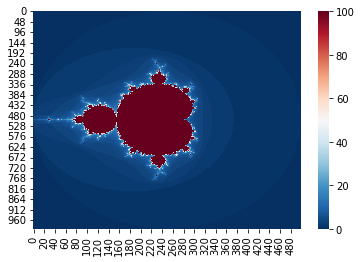

In [ ]:
sns.heatmap(res, cmap="RdBu_r")
plt.show()

## Shared Memory

In [ ]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import pycuda.autoinit

In [ ]:
module = SourceModule("""
#define NUM_THREADS 128
#define NUM_HALO 2
__global__ void rolling_mean_1d(int nx, float *res, float *arr){
    __shared__ float arr_s[NUM_THREADS + NUM_HALO];
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int tx = threadIdx.x + 1;
    float arr_mean;
    if (x < nx){
        arr_s[tx] = arr[x];
        if (x == 0){
            arr_s[tx - 1] = arr[0];
        } else if (x == (nx - 1)){
            arr_s[tx + 1] = arr[nx - 1];
        } else {
            if ((tx - 1) == 0){
                arr_s[tx - 1] = arr[x - 1];
            } else if ((tx + 1) == NUM_THREADS){
                arr_s[tx + 1] = arr[x + 1];
            }
        }
        __syncthreads();
        arr_mean = (arr_s[tx - 1] + arr_s[tx] + arr_s[tx + 1]) / 3.0;
        res[x] = arr_mean;
    }
}
""")

In [ ]:
rolling_mean = module.get_function("rolling_mean_1d")

In [ ]:
num_components = np.int32(200)
x = np.linspace(0, 5, num_components, dtype=np.float32)

In [ ]:
arr = np.sin(x) + 0.1 * np.random.randn(num_components).astype(np.float32)

In [ ]:
arr_gpu = gpuarray.to_gpu(arr)
res_gpu = gpuarray.zeros(num_components, dtype=np.float32)

In [ ]:
num_threads = 128
threads_per_block = (num_threads, 1, 1)
blocks_per_grid = (math.ceil(num_components / threads_per_block[0]), 1, 1)

In [ ]:
rolling_mean(num_components, res_gpu, arr_gpu, block=threads_per_block, grid=blocks_per_grid)

In [ ]:
res = res_gpu.get()

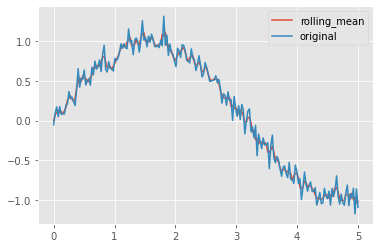

In [ ]:
plt.plot(x, res, label = "rolling_mean")
plt.plot(x, arr, label = "original")
plt.legend()
plt.show()

##Texture memory 1D

In [ ]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [ ]:
module = SourceModule("""
texture<int, 1, cudaReadModeElementType> tex_1d;
__global__ void read_texture_1d(int nx, int *res){
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    if (x < nx){
        res[x] = tex1Dfetch(tex_1d, x);
    }
}
""")

In [ ]:
read_tex_1d = module.get_function("read_texture_1d")

In [ ]:
num_components = np.int32(10)
arr = np.arange(num_components, dtype=np.int32)

In [ ]:
np.random.shuffle(arr)

In [ ]:
print(arr)

[2 8 3 4 1 5 9 0 7 6]


In [ ]:
arr_gpu = gpuarray.to_gpu(arr)
res_gpu = gpuarray.zeros(num_components, dtype=np.int32)

In [ ]:
tex_1d = module.get_texref("tex_1d")
arr_gpu.bind_to_texref_ext(tex_1d)

0.0

In [ ]:
thread_per_block = (256, 1, 1)
blocks_per_grid = (math.ceil(num_components / threads_per_block[0]), 1, 1)

In [ ]:
read_tex_1d(num_components, res_gpu, block=threads_per_block, grid=blocks_per_grid, texrefs=[tex_1d])

In [ ]:
res_gpu.get()

array([2, 8, 3, 4, 1, 5, 9, 0, 7, 6], dtype=int32)

##Texture memory 2D

In [ ]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.driver as drv
import pycuda.autoinit

In [ ]:
module = SourceModule("""
texture<int, 2, cudaReadModeElementType> tex_2d;
__global__ void read_texture_2d(int nx, int ny, int *res){
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;
    int ij = nx * y + x;
    if (x < nx && y < ny){
        res[ij] = tex2D(tex_2d, x, y);
    }
}
""")

In [ ]:
read_tex_2d = module.get_function("read_texture_2d")

In [ ]:
num_components = np.int32(20)
arr = np.arange(num_components, dtype=np.int32)

In [ ]:
np.random.shuffle(arr)

In [ ]:
num_x, num_y = np.int32(5), np.int32(4)
arr = arr.reshape(num_y, num_x)

In [ ]:
arr

array([[15,  6,  7,  4, 13],
       [ 8,  2,  9,  0, 11],
       [18,  1, 14, 17,  5],
       [12, 19,  3, 10, 16]], dtype=int32)

In [ ]:
arr_gpu = gpuarray.to_gpu(arr)
res_gpu = gpuarray.zeros([num_y, num_x], dtype=np.int32)

In [ ]:
tex_2d = module.get_texref("tex_2d")

In [ ]:
drv.matrix_to_texref(arr, tex_2d, order="C")

In [ ]:
threads_per_block = (16, 16, 1)
block_x = math.ceil(num_x / threads_per_block[0])
block_y = math.ceil(num_y / threads_per_block[1])
blocks_per_grid = (block_x, block_y, 1)

In [ ]:
read_tex_2d(num_x, num_y, res_gpu, block=threads_per_block, grid=blocks_per_grid, texrefs=[tex_2d])

In [ ]:
res_gpu.get()

array([[15,  6,  7,  4, 13],
       [ 8,  2,  9,  0, 11],
       [18,  1, 14, 17,  5],
       [12, 19,  3, 10, 16]], dtype=int32)

##Texture Memory 3D

In [20]:
import pycuda.driver as drv


def bind_array_to_texture3d(np_array, tex_ref):
    """
    generate array for texture3d based on numpy array
    :param np_array:
    :param tex_ref:
    :return: array for binding to texture reference
    """
    # get shape
    # caution: (d, h, w) C manner
    #        : (w, h, d) Fortran manner
    #
    d, h, w = np_array.shape
    # generate descriptor
    descr = drv.ArrayDescriptor3D()
    descr.width = w
    descr.height = h
    descr.depth = d
    descr.format = drv.dtype_to_array_format(np_array.dtype)
    descr.num_channels = 1
    descr.flags = 0
    device_array = drv.Array(descr)
    # method for copy
    copy = drv.Memcpy3D()
    copy.set_src_host(np_array)
    copy.set_dst_array(device_array)
    copy.width_in_bytes = copy.src_pitch = np_array.strides[1]
    copy.src_height = copy.height = h
    copy.depth = d
    copy()
    # bind array to texture 3d
    tex_ref.set_array(device_array)


if __name__ == "__main__":
    pass


In [ ]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [ ]:
module = SourceModule("""
texture<int, 3, cudaReadModeElementType> tex_3d;
__global__ void read_texture_3d(int nx, int ny, int nz, int *res){
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;
    int z = threadIdx.z + blockDim.z * blockIdx.z;
    int ijk = nx * ny * z + nx * y + x;
    if (x < nx && y < ny && z < nz){
        res[ijk] = tex3D(tex_3d, x, y, z);
    }
}
""")

In [ ]:
read_tex_3d = module.get_function("read_texture_3d")

In [ ]:
num_components = np.int32(24)

In [ ]:
arr = np.arange(num_components, dtype=np.int32)

In [ ]:
np.random.shuffle(arr)

In [ ]:
num_x, num_y, num_z = np.int32(2), np.int32(3), np.int32(4)

In [ ]:
arr = arr.reshape(num_z, num_y, num_x)

In [ ]:
print(arr)

[[[17  6]
  [20  4]
  [ 5 21]]

 [[ 3 15]
  [ 9 22]
  [19 11]]

 [[10  1]
  [14 12]
  [16  8]]

 [[18  2]
  [ 0  7]
  [13 23]]]


In [ ]:
arr_gpu = gpuarray.to_gpu(arr)
res_gpu = gpuarray.zeros([num_z, num_y, num_x], dtype=np.int32)

In [ ]:
tex_3d = module.get_texref("tex_3d")

In [ ]:
bind_array_to_texture3d(arr, tex_3d)

In [ ]:
threads_per_block = (6, 6, 6)
block_x = math.ceil(num_x / threads_per_block[0])
block_y = math.ceil(num_y / threads_per_block[1])
block_z = math.ceil(num_z / threads_per_block[2])
blocks_per_grid = (block_x, block_y, block_z)

In [ ]:
read_tex_3d(num_x, num_y, num_z, res_gpu, block=threads_per_block, grid=blocks_per_grid, texrefs=[tex_3d])

In [ ]:
res_gpu.get()

array([[[17,  6],
        [20,  4],
        [ 5, 21]],

       [[ 3, 15],
        [ 9, 22],
        [19, 11]],

       [[10,  1],
        [14, 12],
        [16,  8]],

       [[18,  2],
        [ 0,  7],
        [13, 23]]], dtype=int32)

## scan kernel

In [2]:
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.scan import InclusiveScanKernel
import pycuda.autoinit

In [3]:
scan_kernel = InclusiveScanKernel(np.int32, "a+b")

In [4]:
arr = np.arange(10, dtype=np.int32)
arr_gpu = gpuarray.to_gpu(arr)

In [5]:
arr_gpu2 = arr_gpu.copy()

In [6]:
scan_kernel(arr_gpu2)

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45], dtype=int32)

In [9]:
np.cumsum(arr)

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])

## Atomic

In [10]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [11]:
module = SourceModule("""
__global__ void sum_atomic(int nx, int *sum, int *data){
  int x = threadIdx.x + blockDim.x * blockIdx.x;
  if (x < nx){
     atomicAdd(sum, data[x]);
  }
}

""")

In [12]:
atomic_sum = module.get_function("sum_atomic")

In [13]:
nx = np.int32(10)
arr = np.arange(nx, dtype=np.int32)

In [14]:
sum_gpu = gpuarray.zeros(1, dtype=np.int32)
arr_gpu = gpuarray.to_gpu(arr)

In [15]:
threads_per_block = (256, 1, 1)
blocks_per_grid = (math.ceil(nx / threads_per_block[0]), 1, 1)

In [16]:
atomic_sum(nx, sum_gpu, arr_gpu, block=threads_per_block, grid=blocks_per_grid)

In [17]:
sum_gpu.get()

array([45], dtype=int32)

In [18]:
np.sum(arr)

45

## Reduction

In [19]:
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.reduction import ReductionKernel
import pycuda.autoinit

In [21]:
arr1 = np.array([3, 2, 2], dtype=np.float32)
arr2 = np.array([2, -1, 3], dtype=np.float32)

In [22]:
arr1_gpu = gpuarray.to_gpu(arr1)
arr2_gpu = gpuarray.to_gpu(arr2)

In [23]:
reduction_kernel = ReductionKernel(np.float32, neutral="0",
                                  reduce_expr="a+b", map_expr="x[i]*y[i]",
                                  arguments="float *x, float *y")

In [25]:
reduction_kernel(arr1_gpu, arr2_gpu)

array(10., dtype=float32)

In [26]:
np.dot(arr1, arr2)

10.0

## min/max scan kernel

In [1]:
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.scan import InclusiveScanKernel
import pycuda.autoinit

In [2]:
scan_kernel = InclusiveScanKernel(np.int32, "a > b ? a: b")

In [3]:
arr = np.arange(10, dtype=np.int32)

In [4]:
np.random.shuffle(arr)

In [5]:
arr_gpu = gpuarray.to_gpu(arr)

In [6]:
arr_gpu2 = arr_gpu.copy()

In [7]:
scan_kernel(arr_gpu2)

array([3, 8, 8, 9, 9, 9, 9, 9, 9, 9], dtype=int32)

In [8]:
np.max(arr)

9

## min/max cuBLAS

In [9]:
!pip3 install scikit-cuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 7.3 MB/s 


In [10]:
import numpy as np
import pycuda.gpuarray as gpuarray
from skcuda import cublas
import pycuda.autoinit

/usr/local/lib/python3.8/dist-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [11]:
np.random.seed(42)
arr = np.random.randint(1, 100, 20, dtype=np.int32)

In [12]:
arr

array([52, 93, 15, 72, 61, 21, 83, 87, 75, 75, 88, 24,  3, 22, 53,  2, 88,
       30, 38,  2], dtype=int32)

In [13]:
arr_gpu = gpuarray.to_gpu(arr)

/usr/local/lib/python3.8/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


In [14]:
h = cublas.cublasCreate()
max_id = cublas.cublasIsamax(h, arr_gpu.size, arr_gpu.gpudata, 1)
min_id = cublas.cublasIsamin(h, arr_gpu.size, arr_gpu.gpudata, 1)
cublas.cublasDestroy(h)

In [15]:
max_id

1

In [16]:
min_id

15

In [17]:
np.argmax(arr)

1

In [18]:
np.argmin(arr)

15

## Thrust sorting

In [19]:
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [20]:
module = SourceModule("""
#include <thrust/sort.h>
#include <thrust/execution_policy.h>
extern "C"{
__global__ void sort_thrust(int num_component, int *arr){
thrust::sort(thrust::device, arr, arr + num_component);
}

__global__ void sort_by_key_thrust(int num_component, int *key, int *arr){
thrust::sort_by_key(thrust::device, key, key + num_component, arr);
}
}
""", no_extern_c=True)

In [21]:
sort_thrust = module.get_function("sort_thrust")
sort_by_key_thrust = module.get_function("sort_by_key_thrust")

In [22]:
nx = np.int32(6)
arr = np.arange(nx, dtype=np.int32)

In [23]:
np.random.shuffle(arr)

In [24]:
arr

array([5, 2, 1, 0, 4, 3], dtype=int32)

In [25]:
arr_gpu = gpuarray.to_gpu(arr)
arr_gpu2 = arr_gpu.copy()

In [26]:
sort_thrust(nx, arr_gpu, block=(1, 1, 1), grid=(1, 1, 1))

In [28]:
arr_gpu.get()

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [30]:
key = np.arange(nx, 0, -1, dtype=np.int32)

In [31]:
key_gpu = gpuarray.to_gpu(key)

In [32]:
sort_by_key_thrust(nx, key_gpu, arr_gpu2, block=(1, 1, 1), grid=(1, 1, 1))

In [33]:
arr_gpu2.get()

array([3, 4, 0, 1, 2, 5], dtype=int32)

In [34]:
arr

array([5, 2, 1, 0, 4, 3], dtype=int32)

In [35]:
key

array([6, 5, 4, 3, 2, 1], dtype=int32)

## template

In [3]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [5]:
module = SourceModule("""
template <class T>
__device__ T add_two_vector(T x, T y){
  return (x + y);
}
extern "C"{
__global__ void add_two_vector_kernel(int nx, int *a, int *b, int *res){
  int x = threadIdx.x + blockDim.x * blockIdx.x;
  if (x < nx){
    res[x] = add_two_vector<int>(a[x], b[x]);
  }
}
}
""", no_extern_c=True)


In [6]:
add_two_vector = module.get_function("add_two_vector_kernel")

In [7]:
num_components = np.int32(10)
x = np.arange(num_components, dtype=np.int32)

In [8]:
np.random.seed(42)
y = np.random.randint(0, 10, num_components, dtype=np.int32)

In [9]:
x_gpu = gpuarray.to_gpu(x)
y_gpu = gpuarray.to_gpu(y)

In [10]:
res_gpu = gpuarray.zeros(num_components, dtype=np.int32)

In [12]:
threads_per_block = (256, 1, 1)
blocks_per_grid = (math.ceil(num_components/threads_per_block[0]), 1, 1)

In [13]:
add_two_vector(num_components, x_gpu, y_gpu, res_gpu, block=threads_per_block, grid=blocks_per_grid)

In [14]:
res_gpu.get()

array([ 6,  4,  9,  7, 10, 14,  8, 13, 15, 13], dtype=int32)

In [15]:
x + y

array([ 6,  4,  9,  7, 10, 14,  8, 13, 15, 13], dtype=int32)

## dynamic parallelism

In [1]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import DynamicSourceModule
import pycuda.autoinit

In [2]:
module = DynamicSourceModule("""
__global__ void add_two_vector(int nx, float *arr1, float *arr2, float *res){
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    if (x < nx){
        res[x] = arr1[x] + arr2[x];
    }
}
__global__ void add_two_vector_dynamic(int *grid, int *block, int nx, float *arr1, float *arr2, float *res){
dim3 grid_ = dim3(grid[0], grid[1], grid[2]);
dim3 block_ = dim3(block[0], block[1], block[2]);
add_two_vector<<<grid_, block_>>>(nx, arr1, arr2, res);
}
""")

In [3]:
add_two_vector_dynamic = module.get_function("add_two_vector_dynamic")

In [4]:
num_comp = np.int32(10)
arr1 = np.arange(num_comp, dtype=np.float32)
arr2 = np.arange(num_comp, dtype=np.float32)

In [5]:
np.random.shuffle(arr2)

In [6]:
res_gpu = gpuarray.zeros(num_comp, dtype=np.float32)

In [7]:
threads_per_block = (256, 1, 1)
blocks_per_grid = (math.ceil(num_comp / threads_per_block[0]), 1, 1)

In [8]:
block = np.array(threads_per_block, dtype=np.int32)
grid = np.array(blocks_per_grid, dtype=np.int32)

In [9]:
arr1_gpu = gpuarray.to_gpu(arr1)
arr2_gpu = gpuarray.to_gpu(arr2)
block_gpu = gpuarray.to_gpu(block)
grid_gpu = gpuarray.to_gpu(grid)

In [10]:
add_two_vector_dynamic(grid_gpu, block_gpu, num_comp, arr1_gpu, arr2_gpu, res_gpu, block=(1, 1, 1), grid=(1, 1, 1))

In [11]:
res_gpu.get()

array([ 9.,  4.,  9.,  5.,  4., 10., 14., 13., 12., 10.], dtype=float32)

In [12]:
arr1 + arr2

array([ 9.,  4.,  9.,  5.,  4., 10., 14., 13., 12., 10.], dtype=float32)